# Atmospheric escape
by Maxime Maurice (maxime.maurice@rice.edu)

### Dependencies and Packages

## Calculation of the maximum mass of H lost
An upper bound of the of the H escape is provided by the energy-limited escap. Following Katyal *et al*., 2020, we use the parametrizatoin fro energy-limited escape:   
$\dot{M}_{\rm esc}=\frac{\pi\epsilon F_{\rm XUV}(t)}{GM_p}$

In [1]:
import numpy as np
from physics.constants import *
from utils import y2s
from scipy.integrate import quad
from scipy.constants import G

### XUV parametrizations and efficiency
For the evolution of the XUV flux  of the sun is given by: $F_{\rm XUV}(t)=5(4.5/t)^{1.24}$, where $F_{\rm XUV}$ is in erg/cm$^2$/s, and $t$ in Gyr (don't forget to translate everything in SI!).

In [2]:
# XUV flux of the young sun
F_XUV      = lambda t:5*(4.5/(t/y2s/1e9))**1.24*1e-7*1e4 # [W/m²]
efficiency = 0.5 # [-]

### Maximum H mass lost over Earth's history

In [3]:
M_H_lost = quad(lambda t: np.pi*efficiency*Earth_surface_radius**3*F_XUV(t)/G/Earth_mass,100*1e6*y2s,4.5*1e9*y2s)
print(M_H_lost[0]*9/EO_mass,'Earth ocean may have been lost by energy-limited escape since 100 Myr after CAIs')

32.387077666459014 Earth ocean may have been lost by energy-limited escape since 100 Myr after CAIs


### Maximum H mass lost over 3 Myr

In [4]:
M_H_lost = np.pi*efficiency*Earth_surface_radius**3*F_XUV(100*1e6*y2s)/G/Earth_mass*3*y2s
print(M_H_lost*9/EO_mass,'Earth ocean may have been lost by energy-limited escape since 100 Myr after CAIs')

3.893445478887922e-07 Earth ocean may have been lost by energy-limited escape since 100 Myr after CAIs


## Run simulation with atmospheric escape
Let's now implement atmospheric escape as a parametrization for magma oceans. We will compare between 2 escape parametrizations: the energy-limited escape that we already introduced, and a more accurate parametrzation proposed by Zahnle *et al*., 2019

In [5]:
from MO_lib.eq_full import MO as MO1 # MO1 will be the reference magma ocean, without escape
from copy import deepcopy
MO2 = deepcopy(MO1)                  # MO2 will implement energy-limited escape
MO3 = deepcopy(MO1)                  # MO3 will implement the escape parametrization from Zahne et al., 2019

/home/maxime/Models/Radiative_Transfer/pRT/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2_R_10...
 Done.
  Read line opacities of H2O_R_10...
 Done.
  Read line opacities of CO_R_10...
 Done.
  Read line opacities of CO2_R_10...
 Done.

  Read CIA opacities for H2-H2...
Done.



### Atmospheric escape parametrizations
#### Enegy-limited ecape

In [6]:
def energy_limited_escape(dt,MO):
    M_H_lost                   = np.pi*efficiency*Earth_surface_radius**3*F_XUV(100e6*y2s)/G/Earth_mass*dt
    phi_H2                     = efficiency*Earth_surface_radius*F_XUV(100e6*y2s)/G/Earth_mass/4
    MO.content['system']['H'] -= M_H_lost/MO.M_system
    return phi_H2
MO2.setParametrization('phi_H2',lambda var:energy_limited_escape(var['dt'],var['MO']),['dt'],is_profile=False,channel='time-dep')
MO2.RK4_step(0)

0

Parametrization from Zahnle et l., 2019 (eq. 3)

In [7]:
from scipy.constants import N_A
from chemistry.elements import H
def atmospheric_escape_Zahnle2019(f_H2,dt,MO):
    S = 40 # F_XUV /F_XUV today
    phi_H2 = 2e16*f_H2*S/np.sqrt(1+0.006*S**2)/N_A*2*H.atomic_mass/1000 # [kg/m^2/s] (valid for f_H2 < 0.2)
    MO.content['system']['H'] -= 4*np.pi*MO.R_out**2*phi_H2*dt/MO.M_system
    return phi_H2
MO3.setParametrization('f_H2',lambda var:var['atm'].profiles['molar fraction']['H2'][-1],['atm'],is_profile=False,channel='post-spec')
MO3.setParametrization('phi_H2',lambda var:atmospheric_escape_Zahnle2019(var['f_H2'],var['dt'],var['MO']),['f_H2','dt'],is_profile=False,channel='time-dep')
MO3.RK4_step(0)

0

### Time-series

In [8]:
from tools import time_series
ts1=time_series(MO1)
ts1.register('OLR','atm.getOLR()')
ts2=time_series(MO2)
ts2.register('OLR','atm.getOLR()')
ts3=time_series(MO3)
ts3.register('OLR','atm.getOLR()')

ts1.write(0)
ts2.write(0)
ts3.write(0)

### Timestep
We set the initial and maximum timestep. The code has a built-in timestep 'adapater', which increases $dt$ when the potential temperature step is smaller than 1 K (since the flux only reduces with progress of the crystallization, there is no correction in the other direction).

In [9]:
MO1.max_dT = 10
dt1        = 10*y2s
MO2.max_dT = 10
dt2        = 10*y2s
MO3.max_dT = 10
dt3        = 10*y2s

## Let's goooooooooo

In [10]:
for MO,ts,dt in zip([MO2,MO1,MO3],[ts2,ts1,ts3],[dt2,dt1,dt3]):
    while MO.M_system/ts('M_sys')[0] > 0.01:
        dt=MO.RK4_step(dt)
        ts.write(MO.t)

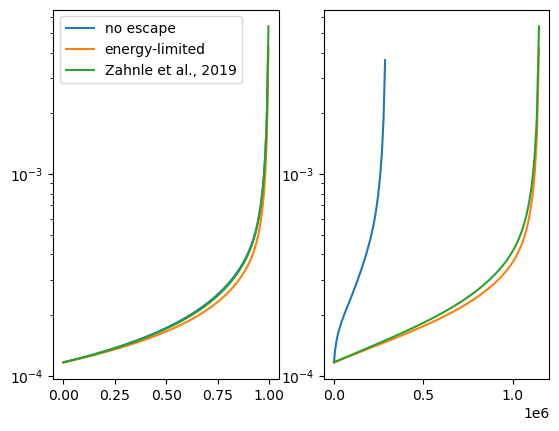

In [11]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.semilogy(1-ts1('M_sys')/ts1('M_sys')[0],ts1('H_system'),label='no escape')
plt.semilogy(1-ts2('M_sys')/ts2('M_sys')[0],ts2('H_system'),label='energy-limited')
plt.semilogy(1-ts3('M_sys')/ts3('M_sys')[0],ts3('H_system'),label='Zahnle et al., 2019')
plt.legend()

from utils import y2s
plt.subplot(122)
plt.semilogy(ts1('time')/y2s,ts1('H_system'),label='no escape')
plt.semilogy(ts2('time')/y2s,ts2('H_system'),label='energy-limited')
plt.semilogy(ts3('time')/y2s,ts3('H_system'),label='Zahnle et al., 2019')

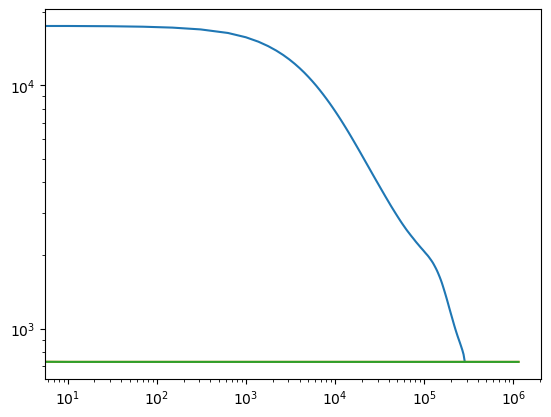

In [13]:
plt.loglog(ts1('time')/y2s,ts1('OLR'),label='no escape')
plt.loglog(ts2('time')/y2s,ts2('OLR'),label='energy-limited')
plt.loglog(ts3('time')/y2s,ts3('OLR'),label='Zahnle et al., 2019')

In [ ]:
print(ts('H_system')[0]/ts2('H_system')[0],ts('H_system')[-1]/ts2('H_system')[-1])
H_lost = sum(ts('phi_H2')[:-1]*np.diff(ts('time'))*4*np.pi*MO.R_out**2*(2*H.atomic_mass))
print(H_lost/ts('H_system')[0]/ts('M_sys')[0])

In [ ]:
from scipy.constants import G, N_A
J_per_erg  = 1e-7
m2_per_cm2 = 1e-4
g_per_kg   = 1e3

M_Earth = 5.97217e24 # [kg]
R_Earth = 6400000    # [m]

def energy_limited_flux(M_p,R_p,R_XUV,F_XUV):
    efficiency = 0.3 # epsilon
    XUV_flow   = np.pi*R_XUV**2*F_XUV
    return efficiency*XUV_flow*R_p/G/M_p # [kg/s] Watson 1981 (cited by Katyal et al., 2020)

def energy_limited_flux2(M_p,R_p,S):
    efficiency = 0.3 # epsilon
    S_EUV      = S*efficiency/4
    m_H        = H.atomic_mass/N_A / g_per_kg
    return S_EUV/(G*M_p*m_H/R_p)

def F_XUV(t):
    #return  5*(4.5/t)**1.24 * J_per_erg/m2_per_cm2 # [W/m^2] Katyal et al., 2020
    return  23.3*t**-1.23 * J_per_erg/m2_per_cm2    # [W/m^2] Catling and Kasting's book

print('F_XUV=',F_XUV(0.1),'W/m²')
print('H escape flux=',energy_limited_flux(M_Earth,R_Earth,R_Earth,F_XUV(0.1)),'kg/s')
print('Mass H lost over 1 Myr =',energy_limited_flux(M_Earth,R_Earth,R_Earth,F_XUV(0.1))*1e6*y2s,'kg = ',energy_limited_flux(M_Earth,R_Earth,R_Earth,F_XUV(0.1))*1e6*y2s/(2/18*EO_mass),' EO')

In [ ]:
plt.plot(ts('time')/y2s/1e6,ts('T_pot'))
plt.plot(ts2('time')/y2s/1e6,ts2('T_pot'))